# **Entendiendo el problema**

Nuestra meta es identificar los circulos sociales de una persona y sus circulos sociales. Cada circulo es un subconjunto de sus amigos. Esto significa que podemos formular el problema de detección de circulos como un problema de agrupamiento de su ego-network.

En la siguiente figura se muestra un único usuario *u* y formamos una red con sus amigos *vi*. Nos referiremos al usuario *u* como *ego* y a sus nodos *vi* como *alters*. La tarea es identificar los circulos a que cada *vi* pertenece. 

<img src="https://i.imgur.com/Ist45yG.png" style="width:700px;">

# **Instalar librerías**

In [ ]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install python-igraph
!pip install cairocffi

# **Importar librerías**

In [1]:
import pickle
import numpy as np
from utils_notebook import *
%matplotlib inline
import pandas as pd
from sklearn.datasets import *
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

## Leer el *path* al dataset

Leemos el dataset como un Pandas Dataframe para analizar los datos.

In [2]:
path = './dataset/com-youtube.ungraph.txt'
data = pd.read_csv(path, sep='\t', skiprows=3)
data.head()

,# FromNodeId,ToNodeId
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


Observamos que el dataset consta de dos columnas que nos indica las conexiones entre nodos.

In [3]:
data.columns

Index([u'# FromNodeId', u'ToNodeId'], dtype='object')

Además nos damos cuenta que hay 2987624 conexiones.

In [4]:
print("Hay", data.to_numpy().shape[0], "conexiones en el dataset de youtube")

('Hay', 2987624, 'conexiones en el dataset de youtube')


Es preciso aclarar, luego de ver las dimensiones de este dataset que, debido a la cantidad de datos para entrenar los algoritmos, estos pueden presentar demoras.

In [5]:
data.describe()

,# FromNodeId,ToNodeId
count,2.987624e+06,2.987624e+06
mean,1.875488e+05,4.128765e+05
std,2.608200e+05,3.392837e+05
min,1.000000e+00,2.000000e+00
25%,1.181500e+04,1.093080e+05
50%,7.680000e+04,3.070595e+05
75%,2.342970e+05,6.864020e+05
max,1.157804e+06,1.157827e+06


Más información acerca de cada columna. El valor máximo *1157804*, menor *1*, la media *187548.8*, la desviación estandar *260820* y la cantidad de datos *2987624*

# Tratamiento de datos

Convertimos el dataframe a un Ndarray de numpy para pasar estos datos a los algoritmos.

In [6]:
np_data = data.to_numpy()

## DBSCAN

Es un algoritmo orientado a la densidad, en donde los clusters son conjuntos de puntos con alta densidad. Un punto pertenece a un cluster si este esta cerca a puntos vecinos agrupados (del montón). El algoritmo DBSCAN puede encontrar clusters con una tamaño y forma arbitraria, además encontrar puntos por fuera y clasificarlos como ruido.

El algoritmo DBSCAN ve los clusters como areas de alta densidad, separadas por areas de baja densidad. Debido a esta visión generica, los clusters encontrados por el DBSCAN pueden ser de cualquier forma, contrario al k-means que asume que los clusters tienen una forma convexa.

La mínima cantidad de nodos y epsilon en el DBSCAN, definen formalmente la densidad. A mayor mínima cantidad de nodos para agrupar y menor epsilon, más densidad es necesaria para formar un cluster

Cuando escogemos un valor bajo para epsilon en el DBSCAN, la gran mayoría de datos no estarán agrupados y serán clasificados como ruido. Por el contrario, cuando utilizamos un valor alto para epsilon ocasionara que todos los nodos esten agrupados.

<img src="https://dashee87.github.io/images/mean_shift_search.gif" style="width:300px;">

Aplicamos una transformación a los datos con el fin de buscar relaciones entre ellos

# Entrenar el modelo y visualizar datos

Entrenaremos un modelo con una porción de datos, con el fin de que no tome mucho tiempo en ejecución y además podamos visualizar el grafo con los nodos etiquetados después del entrenamiento. 

In [16]:
dbscan_data = StandardScaler().fit_transform(np_data) #mean zero and variance one
shunked_data = dbscan_data[:1000]
DBS = DBSCAN(eps=.001)
train_model(DBS, shunked_data)

('Number of labels:', 7)


/media/juanmarcon/IDisk/Proyecto/python2/local/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Number of labels: 7
...


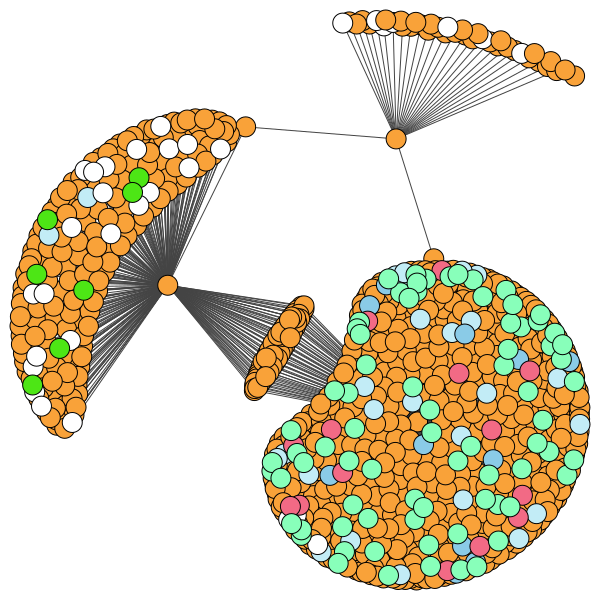

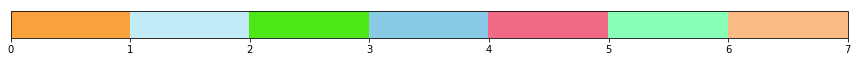

In [8]:
n_labels = len(np.unique(DBS.labels_))
colors = rand_cmap(n_labels, first_color_black=False)
cdict = get_color_dict(colors)
print('...')
plot_graph(DBS.labels_, shunked_data, cdict, 'DBSCAN')

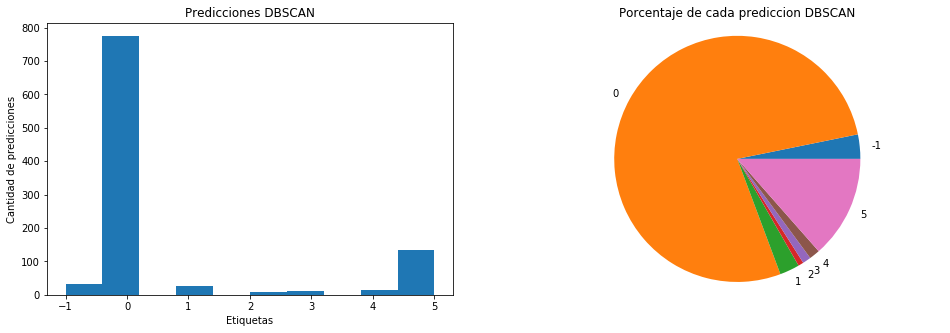

In [9]:
sizes = [100.0*np.count_nonzero(DBS.labels_ == x)/len(DBS.labels_) for x in np.unique(DBS.labels_)]

fig, ax = plt.subplots(ncols=2, figsize=(16,5))

n, bins, patches = ax[0].hist(DBS.labels_)
ax[0].set_xlabel('Etiquetas');
ax[0].set_ylabel('Cantidad de predicciones');
ax[0].set_title('Predicciones DBSCAN');

ax[1].pie(sizes, labels=np.unique(DBS.labels_));
ax[1].set_title('Porcentaje de cada prediccion DBSCAN');
ax[1].axis('equal');

In [10]:
for label, perc in zip(np.unique(DBS.labels_), sizes):
    print("El porcentaje para la etiqueta", label, "es del", perc)

('El porcentaje para la etiqueta', -1, 'es del', 3.2)
('El porcentaje para la etiqueta', 0, 'es del', 77.5)
('El porcentaje para la etiqueta', 1, 'es del', 2.6)
('El porcentaje para la etiqueta', 2, 'es del', 0.7)
('El porcentaje para la etiqueta', 3, 'es del', 1.1)
('El porcentaje para la etiqueta', 4, 'es del', 1.4)
('El porcentaje para la etiqueta', 5, 'es del', 13.5)


# Entrenamos con la totalidad del dataset

Recomendamos no utilizar la función para visualizar el grafo con todos los datos. Llamar a esta función llevaríá a una larga espera aun en un computador con buenas caracteristicas.

In [ ]:
DBS_total = DBSCAN(eps=.001)
train_model(DBS_total, dbscan_data)

# Estadisticas

In [10]:
with open('scripts/stats.pickle', 'rb') as f:
    all_labels = pickle.load(f)
frec = np.array([np.count_nonzero(all_labels == x) for x in np.unique(all_labels)])

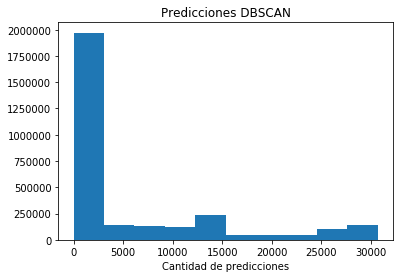

In [13]:
plt.hist(all_labels)
plt.xlabel('Etiquetas');
plt.xlabel('Cantidad de predicciones');
plt.title('Predicciones DBSCAN');

In [14]:
pd.DataFrame({ 
    'Etiqueta': pd.Series(np.unique(all_labels)), 
    'Frecuencia': pd.Series(frec), 
    'Porcentaje': pd.Series(100.0*frec/len(all_labels)) 
})

,Etiqueta,Frecuencia,Porcentaje
0,-1,520334,17.416315
1,0,1239714,41.494981
2,1,418,0.013991
3,2,112074,3.751275
4,3,13,0.000435
5,4,5703,0.190887
6,5,6,0.000201
7,6,18,0.000602
8,7,34,0.001138
9,8,5,0.000167


In [22]:
pd.DataFrame({ 
    'Network statistics': pd.Series(["Number of nodes", "Number of edges"]), 
    '': pd.Series([len(np.unique(dbscan_data)), len(dbscan_data)])
})

,,Network statistics
0,1508925,Number of nodes
1,2987624,Number of edges


In [23]:
pd.DataFrame({ 
    'Community statistics': pd.Series(["Number of communities", "Average community size"]), 
    '': pd.Series([len(np.unique(all_labels)), np.mean(frec)])
})

,,Community statistics
0,30724.000000,Number of communities
1,97.240724,Average community size


# Conclusiones

- El algoritmo DBSCAN es deterministico, siempre genera los mismos clusters cuando se le dan los datos en el mismo orden.

- DBScan es mas amigable porque no necesita el numero de clusters como parametro, mientras el KMeans si lo necesita.

- Cuando no se conoce la cantidad de clusters escondidos en un dataset y no hay manera de visualizarlo, es una buena decisión utilizar el DBSCAN.

- DBSCAN no trabaja muy bien en clusters con diferentes densidades y necesita una selección cuidadosa de sus parametros.

- A pesar de tener un tiempo mayor de ejecución que el algoritmo de centralidad por intermediación y el KMeans, escogemos el DBSCAN como el algoritmo ideal para un analisis de las redes sociales. La razón principal es porque estamos tratando con grandes cantidades de datos, díficiles de visualizar y por lo tanto, de manera intuitiva, no podemos hacer una selección cuidadosa de un parametro como el número de clusters en el KMeans.